In [1]:
# Import necessary libraries
import os
import numpy as np
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator

In [2]:
# Define directory paths and file names
image_folder = '102flowers'      # Folder containing the flower images
segmentation_folder = '102segmentations'  # Folder containing segmentation masks
label_file = 'imagelabels.mat'   # File containing image labels
setid_file = 'setid.mat'         # File containing data splits

In [3]:
# Load image labels from imagelabels.mat
label_data = loadmat(label_file)
labels = label_data['labels'][0]

# Load data splits from setid.mat
setid_data = loadmat(setid_file)
train_ids = setid_data['trnid'][0] - 1  # Adjust indices to start from 0
val_ids = setid_data['valid'][0] - 1   # Adjust indices to start from 0
test_ids = setid_data['tstid'][0] - 1  # Adjust indices to start from 0

In [4]:
# Data augmentation setup with custom preprocessing functions
def adjust_dynamic_range(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def preprocess_function(image):
    # Standard normalization with ImageNet mean and std
    mean = np.array([123.68, 116.779, 103.939])
    std = np.array([58.393, 57.12, 57.375])
    return (image - mean) / std

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda x: adjust_dynamic_range(preprocess_function(x))
)

In [5]:
# Function to preprocess images
def preprocess_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image_array = img_to_array(image)
    # Subtract ImageNet mean pixel values
    mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    image_array -= mean
    return image_array


def load_and_preprocess_images(image_folder, image_ids, labels, target_size):
    images = []
    image_labels = []
    for image_id in image_ids:
        image_path = os.path.join(image_folder, f'image_{image_id + 1:05d}.jpg')
        if os.path.exists(image_path):
            image_array = preprocess_image(image_path, target_size)
            images.append(image_array)
            image_labels.append(labels[image_id])
        else:
            print(f"Image file not found: {image_path}")
    return np.array(images), np.array(image_labels)

In [6]:
# Preprocess training images
target_size = (224, 224)
train_images, train_labels = load_and_preprocess_images(image_folder, train_ids, labels, target_size)

# Preprocess validation images
val_images, val_labels = load_and_preprocess_images(image_folder, val_ids, labels, target_size)

# Preprocess testing images
test_images, test_labels = load_and_preprocess_images(image_folder, test_ids, labels, target_size)

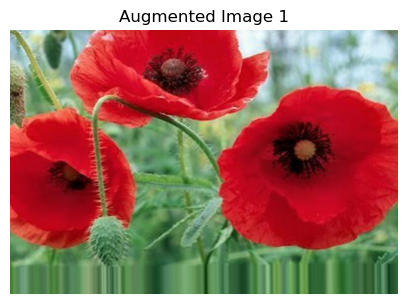

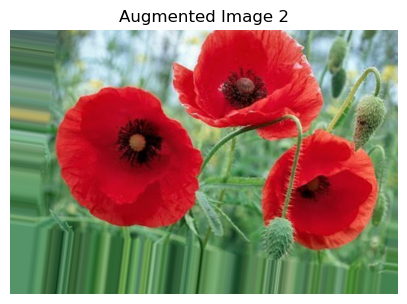

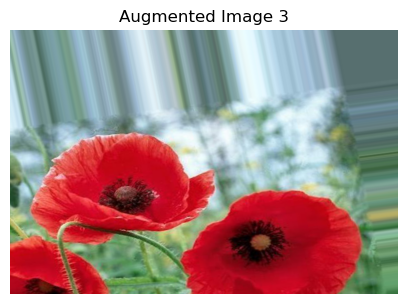

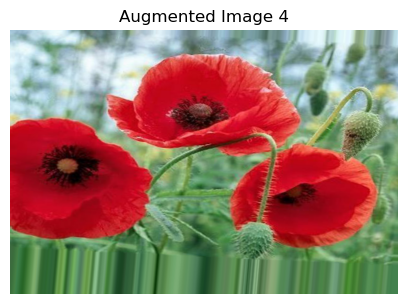

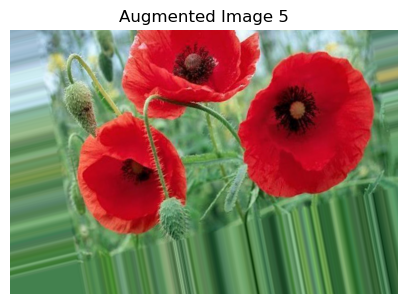

In [7]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Select a random image for augmentation
random_image_path = np.random.choice(os.listdir(image_folder))
sample_image = Image.open(os.path.join(image_folder, random_image_path))
sample_image_array = img_to_array(sample_image)

# Reshape the image array for augmentation
sample_image_array = np.expand_dims(sample_image_array, axis=0)

# Generate augmented images
num_augmented_images = 5
for i, augmented_image_array in enumerate(datagen.flow(sample_image_array, batch_size=1)):
    augmented_image = Image.fromarray(np.uint8(augmented_image_array[0]))
    plt.figure(figsize=(5, 5))
    plt.imshow(augmented_image)
    plt.axis('off')
    plt.title(f'Augmented Image {i+1}')
    plt.show()
    if i + 1 == num_augmented_images:
        break

In [8]:
# Load and examine image labels
label_data = loadmat('imagelabels.mat')
labels = label_data['labels'][0]

print("Labels:", labels)
num_unique_labels = len(set(labels))
print("Number of unique labels:", num_unique_labels)

Labels: [77 77 77 ... 62 62 62]
Number of unique labels: 102


In [9]:
def load_and_preprocess_segmentation_masks(segmentation_folder, image_ids, target_size):
    segmentations = []
    for image_id in image_ids:
        segmentation_path = os.path.join(segmentation_folder, f'segmim_{image_id + 1:05d}.jpg')
        if os.path.exists(segmentation_path):
            segmentation = Image.open(segmentation_path)
            segmentation = segmentation.resize(target_size)
            segmentation_array = img_to_array(segmentation)
            segmentation_array /= 255.0
            segmentations.append(segmentation_array)
        else:
            print(f"Segmentation mask file not found: {segmentation_path}")
            segmentations.append(np.zeros((target_size[0], target_size[1], 1), dtype=np.float32))
    return np.array(segmentations)


# Preprocess segmentation masks for training, validation, and testing
train_segmentations = load_and_preprocess_segmentation_masks(segmentation_folder, train_ids, target_size)
val_segmentations = load_and_preprocess_segmentation_masks(segmentation_folder, val_ids, target_size)
test_segmentations = load_and_preprocess_segmentation_masks(segmentation_folder, test_ids, target_size)

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt

def visualise_random_segmentation_examples(images, segmentations, labels, class_labels, num_examples=3):
    random_indices = np.random.choice(len(images), num_examples, replace=False)
    for idx in random_indices:
        # Normalize or clip the image data to [0, 1] for floats
        image = images[idx].astype(np.float32)  # Ensure image is float32 for processing
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

        # Prepare the segmentation mask, ensuring it's suitable for display
        segmentation_mask = segmentations[idx]
        if segmentation_mask.shape[-1] == 1:
            segmentation_mask = segmentation_mask[:, :, 0]  # If it's single-channel, squeeze it.
        segmentation_mask = (segmentation_mask - segmentation_mask.min()) / (segmentation_mask.max() - segmentation_mask.min())  # Normalize

        # Create figure for original image and segmentation
        plt.figure(figsize=(10, 5))

        # Display the original image
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f'Original Image (Label: {class_labels[labels[idx]]})')
        plt.axis('off')

        # Display the segmentation mask
        plt.subplot(1, 2, 2)
        plt.imshow(segmentation_mask, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')

        plt.show()

# Example usage with dummy data and function call
# Assuming 'train_images', 'train_segmentations', 'train_labels', and 'class_labels' are defined

visualise_random_segmentation_examples(train_images, train_segmentations, train_labels, class_labels)


NameError: name 'class_labels' is not defined

In [ ]:
import scipy.io
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load the .mat file
mat = scipy.io.loadmat('imagelabels.mat')
labels = mat['labels'][0]

# Dictionary mapping from the example
flower_dict = {
    0: 'Pink primrose',
    1: 'Globe thistle',
    # Add the rest of your dictionary here
}

# Path to the directory containing images
image_dir = 'path_to_images/'

# Display a few images with labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Display 5 images
for i, ax in enumerate(axes):
    # Randomly pick an image index
    idx = np.random.randint(len(labels))
    image_path = os.path.join(image_dir, f'image_{idx+1}.jpg')  # adjust based on your image naming
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(flower_dict[labels[idx]])

plt.show()
